# **Detection of Malaria Infection in Human Cells**

# Table of Contents
<a id="contents"></a>
- [**Introduction**](#introduction)
- [**Libraries**](#libraries)
- [**Data Preprocessing**](#data_preprocessing)
  * Import Images
  * Turn filenames and classes into a DataFrame
  * Train-test split
  * Data augmentation
- [**EDA**](#eda)
  * **Class imbalance:** no evidence of class imbalance
  * Visualize the random samples
  * Proportions of Parasitized vs. Uninfected
  * Get first 30% of data from each dataset for further EDA
  * Visualizing the first 30% of data
  * Pixel intensity per color channel
  * **Dimensionality Reduction:** RGB to Grayscale
  * **Dimensionality Reduction:** Principal Component Analysis
- [**Baseline Models**](#baseline)
  * **Baseline Model** - Logistic Regression
  * **Baseline Model** - Support Vector Machine
- [**CNN**](#cnn)
  * CNN without Tuning
  * Final CNN with Tuning
- [**Conclusion & Future Work**](#conclusion)
- [**References**](#ref)

## Introduction <a id="introduction"></a>

Malaria is a deadly disease caused by parasites that are transmitted to humans through the bites of infected mosquitoes. In 2021 alone, there were an estimated 250 million cases of malaria worldwide, resulting in over 600,000 fatalities. Early detection of infected cells is critical to preventing disease progression and alerting health officials of potential outbreaks within a region.

Automating the classification of human cells as diseased or uninfected can facilitate early and accurate detection, particularly in cases where subtle indicators of disease are present. This project aims to develop a deep learning model for detecting malaria infection in human cells. The model will be trained on a dataset of images of infected and healthy cells, utilizing convolutional neural networks (CNNs) to learn features from the images and accurately classify them as infected or healthy. Ultimately, this tool could aid in the timely and effective diagnosis and treatment of malaria, potentially saving countless lives.

## Libraries <a id="libraries"></a>

The code mostly depend on the tensorflow and sklearn libraries to preprocess the data images and construct the models. It also rely on libraries such as matplotlib and seaborn to visualize the data and results.

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from skimage import transform, color
from PIL import Image 

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import svm

import pickle

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)

## Data Preprocessing <a id="data_preprocessing"></a>

The dataset that we explored consists of human cell images that we obtained from the [NIH website](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets). The dataset includes two folders, one for uninfected human cell images and another for malaria-infected human cell images. There are a total of 27560 images with 13780 images in each folder. These images have different sizes, so we resized them all to a uniform 128 × 128 × 3 pixels.

### Import images

In [ ]:
# define path to the directory where images are saved
path = 'data/'

# there will be two classes of images
class_dict = {'Uninfected': 0, 'Parasitized': 1}

# define empty lists to hold the images, the image name, and the class label
filenames = []
classes = []

for label in os.listdir(path):
    # ignore .DS_Store
    if not label.startswith('.') and label in class_dict:
        foldpath = os.path.join(path, label)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filenames.append(fpath)
            classes.append(label)

### Turn filenames and classes into a DataFrame

In [ ]:
df = pd.concat({'Filename': pd.Series(filenames), 'Class': pd.Series(classes)}, axis= 1)
df.head()

Filename        Class
0  data/Parasitized/C118P79ThinF_IMG_20151002_105...  Parasitized
1  data/Parasitized/C189P150ThinF_IMG_20151203_14...  Parasitized
2  data/Parasitized/C91P52ThinF_IMG_20150821_1231...  Parasitized
3  data/Parasitized/C84P45ThinF_IMG_20150818_1012...  Parasitized
4  data/Parasitized/C144P105ThinF_IMG_20151015_16...  Parasitized

### Train-test split

In [ ]:
# train dataframe
train_df, test_and_val_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)

# valid and test dataframe
valid_df, test_df = train_test_split(test_and_val_df,  train_size= 0.6, shuffle= True, random_state= 42)

### Data augmentation

The images are rescaled, rotated, zoomed and flipped. 

The pixel values of the images are rescaled by a factor of 1/255 to normalize the data. 

Rotation is then applied up to a range of 360 degrees, which randomly rotates the images by an angle within this range. This helps the model become invariant to rotation, which is important for classifying images with different orientations.

A zoom range of 0.15 is also applied, which randomly zooms the images by a factor within this range. This helps the model become invariant to scale, which is important for classifying objects of different sizes.

The images are then flipped horizontally and vertically, which reflect the images along the horizontal and vertical axes, respectively. This helps the model become invariant to the orientation of the object within the image.

Finally, a fill_mode of 'constant' and a cval of 0 are used to fill any empty pixels that are created during the transformation process with zeros. This helps ensure that the transformed images have the same dimensions as the original images.

In [ ]:
batch_size = 64
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

test_length = len(test_df)
test_batch_size = max([test_length // n for n in range(1, test_length + 1) if test_length % n == 0 and test_length/n <= 80])
test_steps = test_length // test_batch_size

train_gen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 360,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'constant',
    cval = 0.
)
test_gen = ImageDataGenerator(
    rescale = 1 / 255.0
)

train_gen = train_gen.flow_from_dataframe(train_df, x_col = 'Filename', y_col = 'Class', target_size = img_size, 
                                          class_mode = 'binary', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, x_col = 'Filename', y_col = 'Class', target_size = img_size,
                                         class_mode = 'binary', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col = 'Filename', y_col = 'Class', target_size = img_size, 
                                        class_mode = 'binary', color_mode = 'rgb', shuffle = False,
                                        batch_size = test_batch_size)

Found 22046 validated image filenames belonging to 2 classes.
Found 3307 validated image filenames belonging to 2 classes.
Found 2205 validated image filenames belonging to 2 classes.


## EDA <a id="eda"></a>

### Class imbalance: no evidence of class imbalance

To investigate class imbalance of the dataset, the images that belong to each class are counted. There are no data missingness or class imbalance issues present because 1. this project is dealing with images and 2. a complete dataset is available for both uninfected and parasitized cell images. An equal amount of images in each class also ensures perfect class balance.

In [ ]:
# Count number of images in each class
pd.Series(classes).value_counts().reset_index().rename(columns={'index': 'Class', 0: 'Count'})

Class  Count
0  Parasitized  13780
1   Uninfected  13780

### Visualize the random samples

Let's take a look at 16 randomly picked images from train, validation, and test dataset.

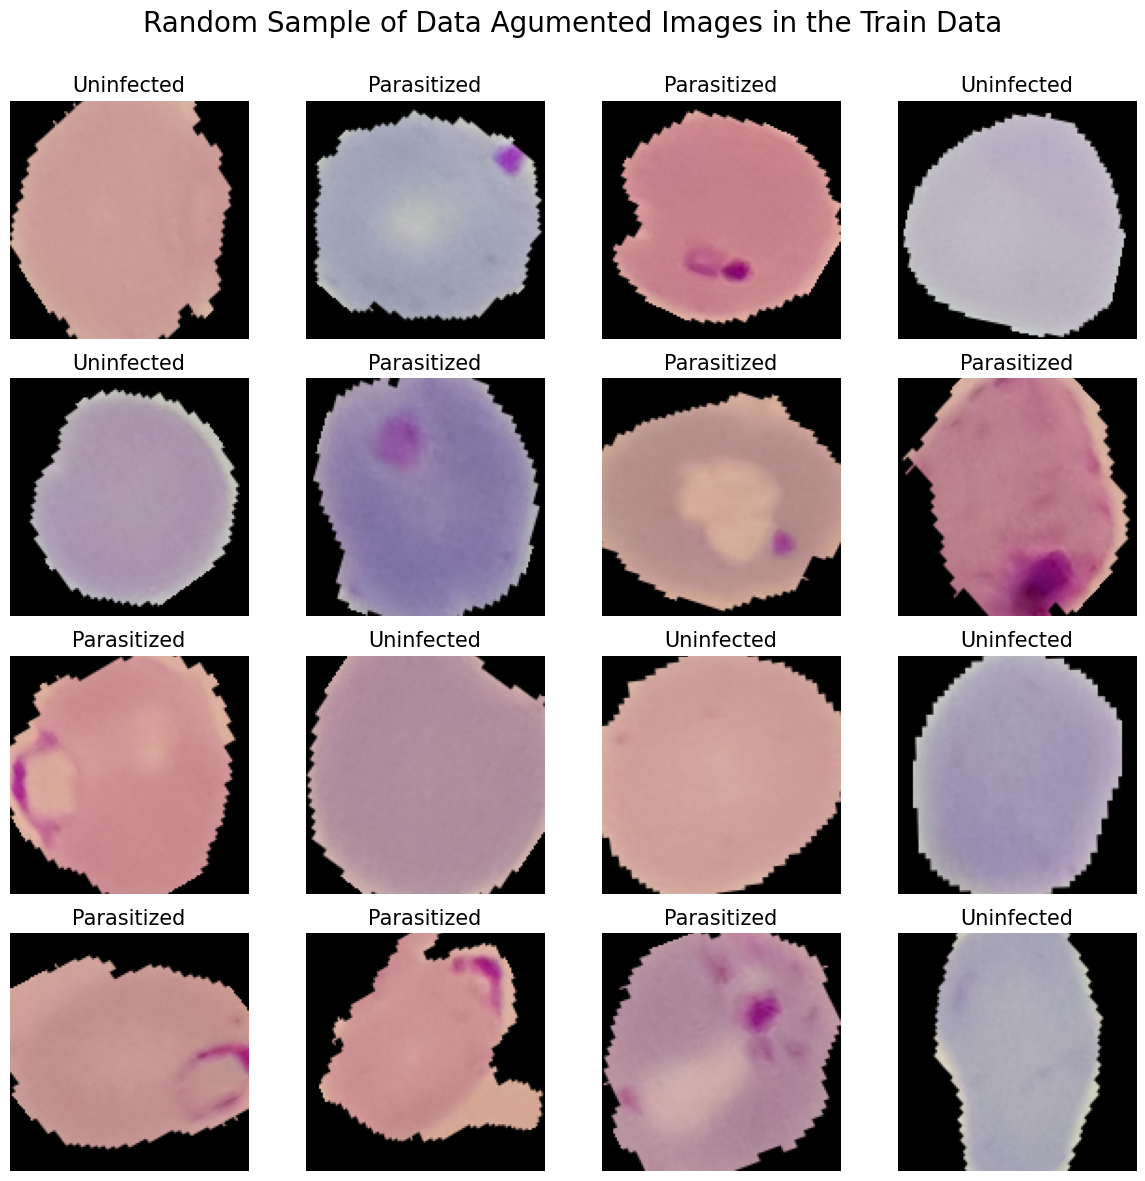

In [ ]:
# Visualising train data
class_dict = train_gen.class_indices
classes = list(class_dict.keys()) 
images, labels = next(train_gen)

length = len(labels)
sample = min(length, 16)

plt.figure(figsize = (12, 12))

for i in range(sample):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = int(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 15)
    plt.axis('off')
plt.suptitle('Random Sample of Data Agumented Images in the Train Data\n', fontsize = 20)
plt.tight_layout()
plt.show();

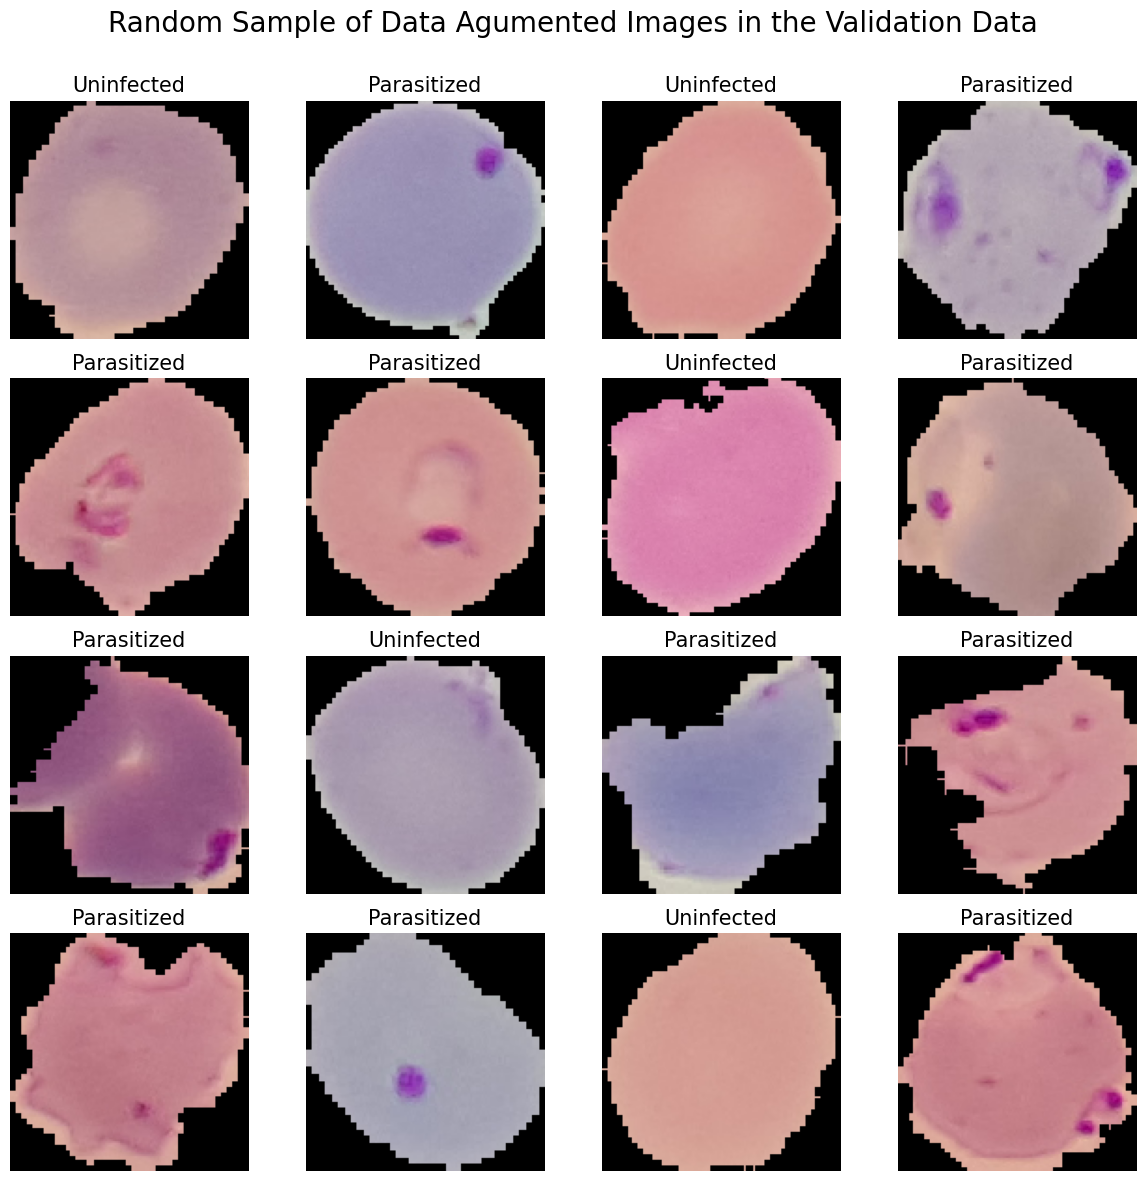

In [ ]:
# Visualising validation data
class_dict = valid_gen.class_indices
classes = list(class_dict.keys()) 
images, labels = next(valid_gen)

length = len(labels)
sample = min(length, 16)

plt.figure(figsize = (12, 12))

for i in range(sample):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = int(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 15)
    plt.axis('off')
plt.suptitle('Random Sample of Data Agumented Images in the Validation Data\n', fontsize = 20)
plt.tight_layout()
plt.show();

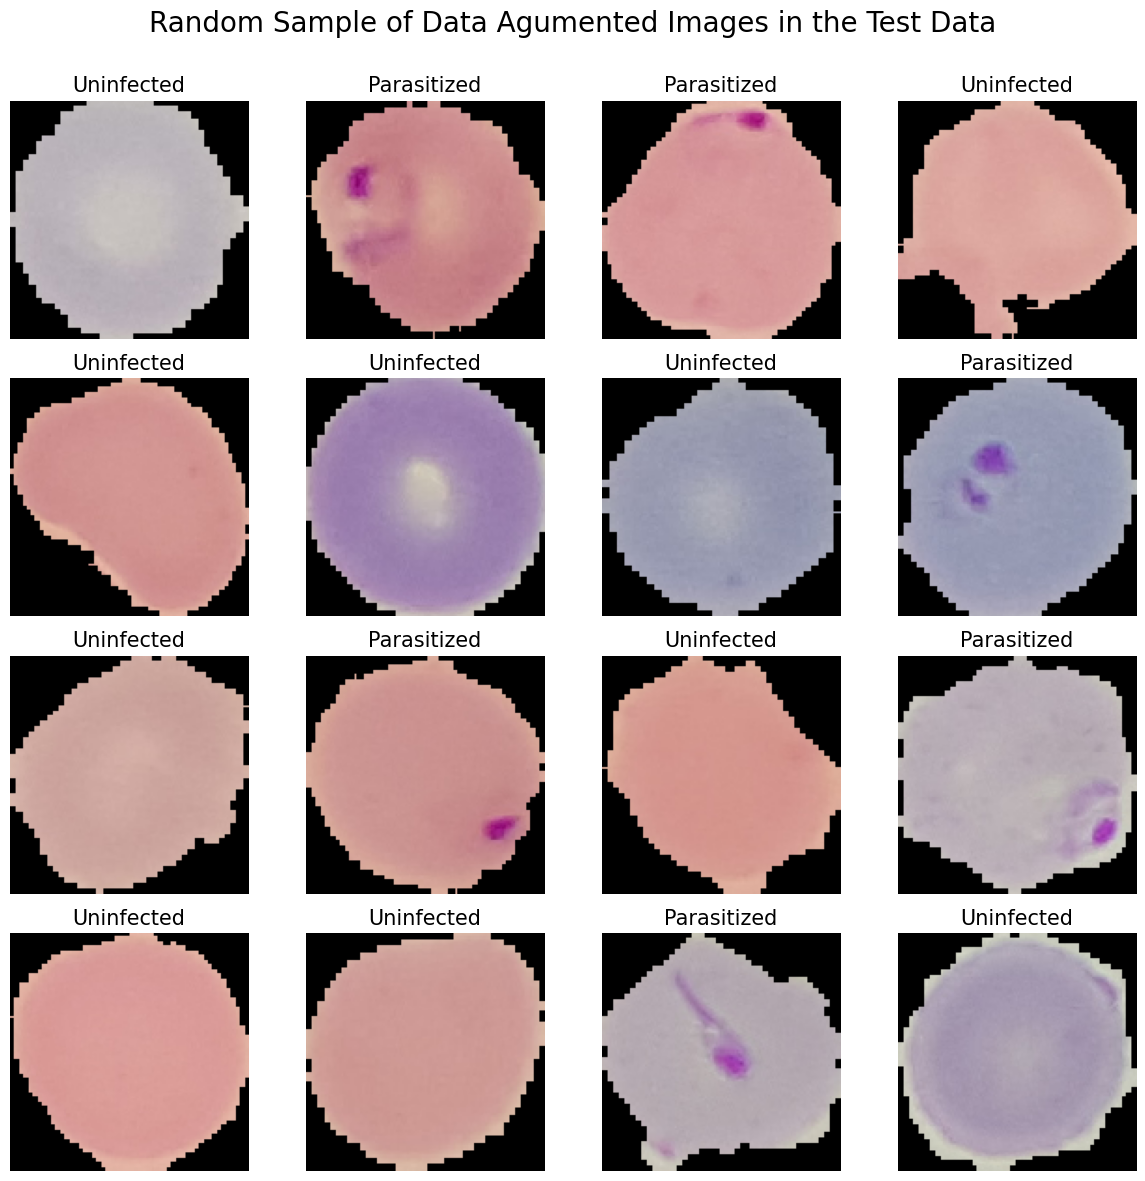

In [ ]:
# Visualising test data
class_dict = test_gen.class_indices
classes = list(class_dict.keys()) 
images, labels = next(test_gen)

length = len(labels)
sample = min(length, 16)

plt.figure(figsize = (12, 12))

for i in range(sample):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = int(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 15)
    plt.axis('off')
plt.suptitle('Random Sample of Data Agumented Images in the Test Data\n', fontsize = 20)
plt.tight_layout()
plt.show();

### Proportions of Parasitized vs. Uninfected

Next, the proportions of healthy and infected cells within each dataset are visualized to ensure class balance. As shown below, the 2 classes are balanced for all 3 datasets.

In [ ]:
def plot_prop(ax, data, title):
    unique, counts = np.unique(data, return_counts = True)
    ax.bar(unique, counts, tick_label = ['Uninfected', 'Parasitized'], color = ['green', 'red'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(title)

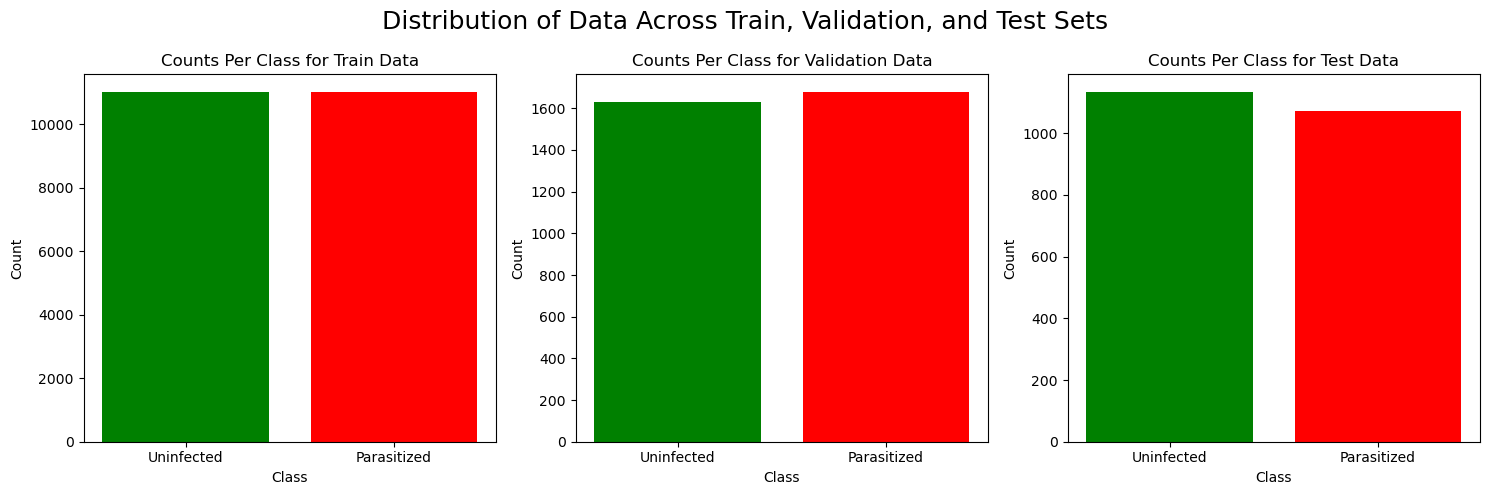

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

plot_prop(axes[0], train_gen.classes, 'Counts Per Class for Train Data')
plot_prop(axes[1], valid_gen.classes, 'Counts Per Class for Validation Data')
plot_prop(axes[2], test_gen.classes, 'Counts Per Class for Test Data')

plt.suptitle('Distribution of Data Across Train, Validation, and Test Sets', fontsize=18)
plt.tight_layout()
plt.show()

### Get first 30% of data from each dataset for further EDA

Due to memory limit, only 30% of the images from each dataset are sampled to perform further analysis and explorations on.

In [ ]:
def get_samples(n, generator):
    generator.reset()
    x_samples = []
    y_samples = []
    for _ in np.arange(n):
        x_batch, y_batch = generator.next()
        x_samples.append(x_batch)
        y_samples.append(y_batch)
    return np.concatenate(x_samples), np.concatenate(y_samples)

def get_class(x_batch, y_batch):
    uninfected = np.array([x_batch[i] for i in np.arange(len(x_batch)) if y_batch[i] == 0])
    parasitized = np.array([x_batch[i] for i in np.arange(len(x_batch)) if y_batch[i] == 1])
    return uninfected, parasitized

In [ ]:
x_train_batch, y_train_batch = get_samples(int(len(train_gen) * 0.3), train_gen) # 102 batches
x_train_batch_uninfected, x_train_batch_parasitized = get_class(x_train_batch, y_train_batch)

x_valid_batch, y_valid_batch = get_samples(int(len(valid_gen) * 0.3), valid_gen) # 14 batches
x_valid_batch_uninfected, x_valid_batch_parasitized = get_class(x_valid_batch, y_valid_batch)

x_test_batch, y_test_batch = get_samples(int(len(test_gen) * 0.3), test_gen) # 10 batches
x_test_batch_uninfected, x_test_batch_parasitized = get_class(x_test_batch, y_test_batch)

In [ ]:
img_arrays = [x_train_batch_uninfected, x_train_batch_parasitized,
              x_valid_batch_uninfected, x_valid_batch_parasitized,
              x_test_batch_uninfected, x_test_batch_parasitized]

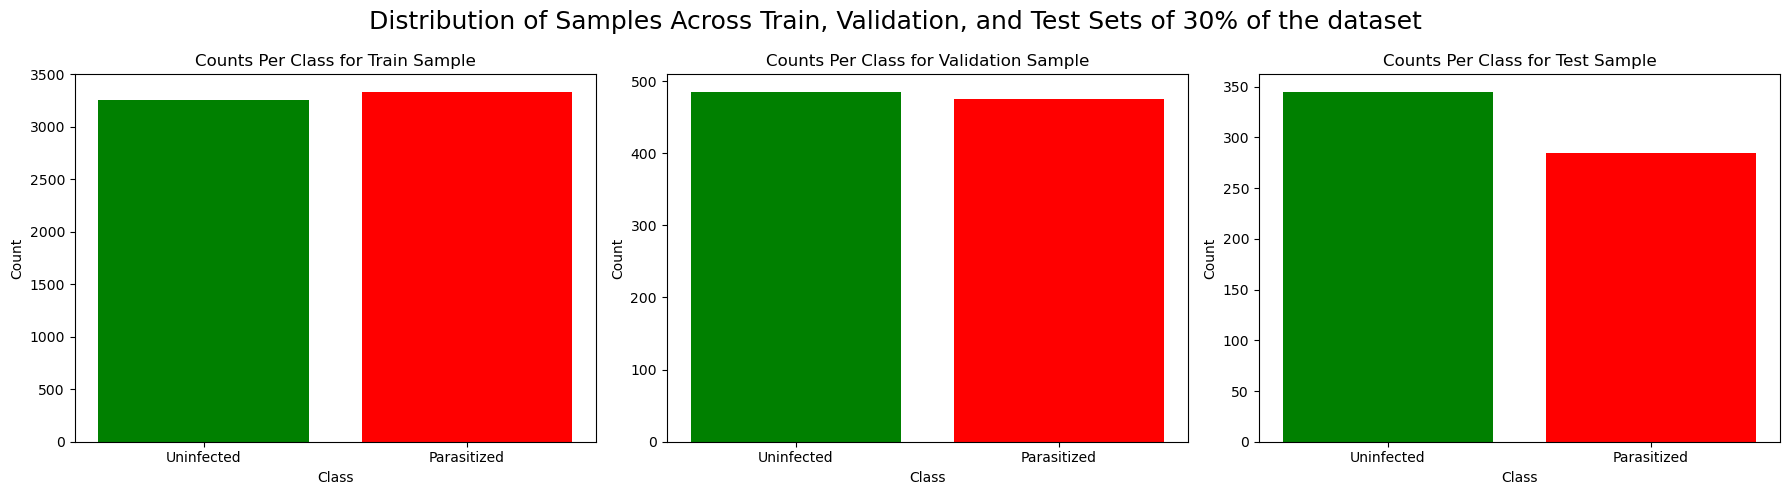

In [ ]:
# Checking for class imbalance for sample batch
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

plot_prop(axes[0], y_train_batch, 'Counts Per Class for Train Sample')
plot_prop(axes[1], y_valid_batch, 'Counts Per Class for Validation Sample')
plot_prop(axes[2], y_test_batch, 'Counts Per Class for Test Sample')

plt.suptitle('Distribution of Samples Across Train, Validation, and Test Sets of 30% of the dataset',fontsize=18)
plt.tight_layout()
plt.show()

No major class imbalance issues are encountered after sampling 30% of the full training, validation, and test datasets.

### Visualizing the first 30% of data

Average image for uninfected and parasitized cells across the first 5 batches of cell images for train, validation, and test data sets

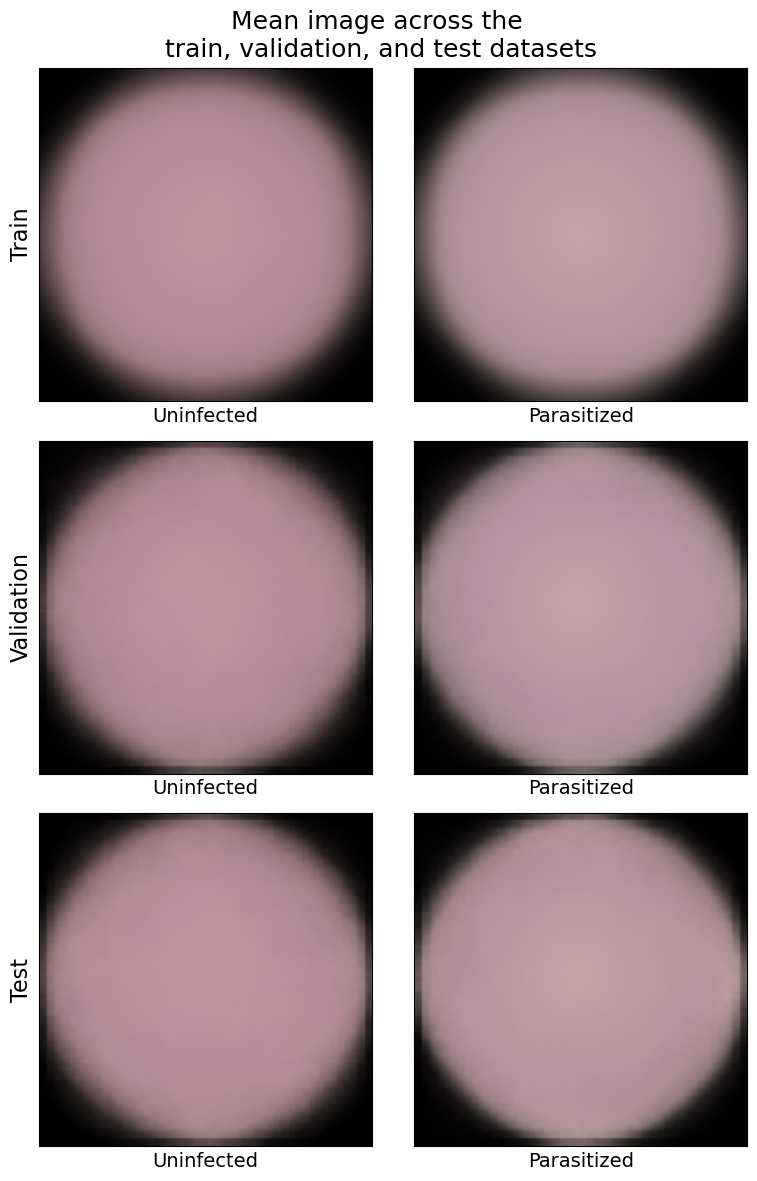

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (8, 12))

titles = ['Train', 'Validation', 'Test']
plt.suptitle('Mean image across the \ntrain, validation, and test datasets',fontsize=18)

for i, arr in enumerate(img_arrays):
    r = i // 2
    c = i % 2
    ax[r, c].imshow(np.mean(arr, axis = 0))
    ax[r, c].set_xticks([])
    ax[r, c].set_yticks([])

    if c == 0:
        ax[r, c].set_xlabel('Uninfected', fontsize = 14)
    else:
        ax[r, c].set_xlabel('Parasitized', fontsize = 14)
    
    ax[r, 0].set_ylabel(titles[r], fontsize = 16)

plt.tight_layout()
#plt.tight_layout(rect = [0, 0, 0.7, 0.7])
plt.show()

### Pixel intensity per color channel

Below are histograms of pixel intensity per color channel for uninfected and parasitized cells across the first 30% of cell images for train, validation, and test data sets. 

The visualization clearly shows some interesting patterns. Specifically, the peak of the green channel for the parasitized cells is higher than that of the uninfected cells for all three datasets. Additionally, the peak of the green channel for the parasitized cells is higher than the first blue channel peak, whereas for the uninfected cells, the peak of the green channel aligns with the first blue channel peak. These findings suggest that the green channel may be more informative in distinguishing between infected and uninfected cells, particularly for parasitized cells.

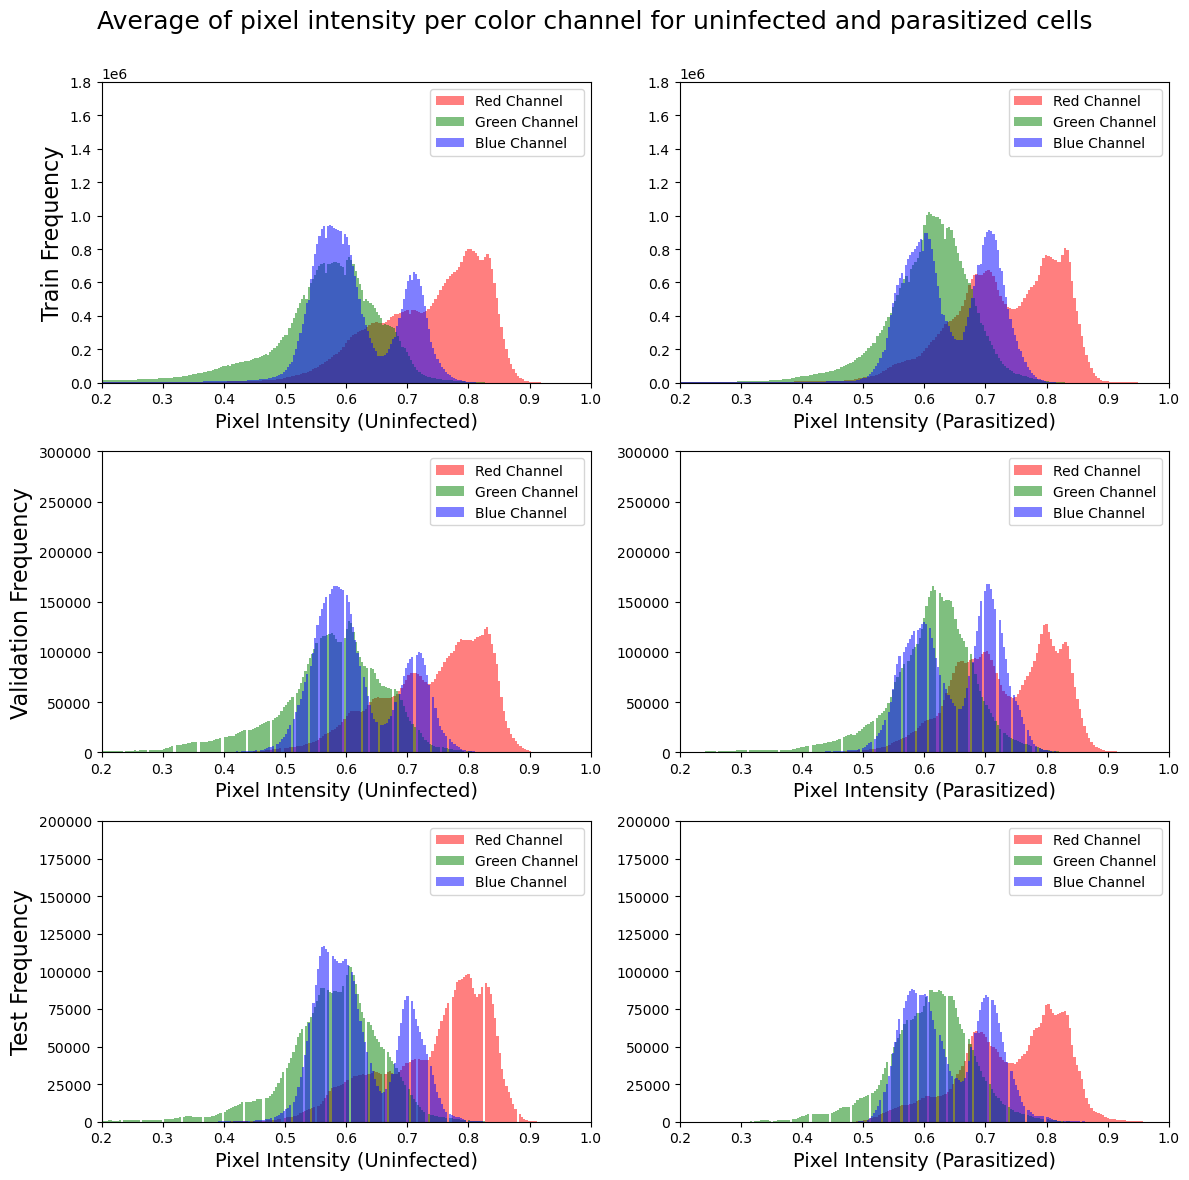

In [ ]:
# Histogram of pixel intensity per color channel
fig, ax = plt.subplots(3, 2, figsize = (12, 12))

titles = ['Train', 'Validation', 'Test']
plt.suptitle('Average of pixel intensity per color channel for uninfected and parasitized cells\n',fontsize=18)
for i, arr in enumerate(img_arrays):
    r = i // 2
    c = i % 2
    ax[r, c].hist(arr[..., 0].ravel(), bins = 256, color = 'red', alpha = 0.5, label = 'Red Channel')
    ax[r, c].hist(arr[..., 1].ravel(), bins = 256, color = 'green', alpha = 0.5, label = 'Green Channel')
    ax[r, c].hist(arr[..., 2].ravel(), bins = 256, color = 'blue', alpha = 0.5, label = 'Blue Channel')
    ax[r, c].set_xlim(0.2, 1)
    ax[r, c].legend()
    
    if r == 0:
        ax[r, c].set_ylim(0, 1800000)
    elif r == 1:
        ax[r, c].set_ylim(0, 300000)
    else:
        ax[r, c].set_ylim(0, 200000)

    if c == 0:
        ax[r, c].set_xlabel('Pixel Intensity (Uninfected)', fontsize = 14)
    else:
        ax[r, c].set_xlabel('Pixel Intensity (Parasitized)', fontsize = 14)
    
    ax[r, 0].set_ylabel(titles[r] + ' Frequency', fontsize = 16)

plt.tight_layout()
plt.show()

Below is the table of average pixel intensity per color channel for uninfected and parasitized cells across the first 30% of cell images for train, validation, and test data sets. The table shows that the average pixel intensity values for parasitized cells are generally higher than those for uninfected cells, regardless of the color channel or dataset. This finding is consistent across all three color channels and is particularly pronounced for the green channel. These results confirm what was observed in the earlier histogram analysis, which suggested that the green channel may be a more important feature for distinguishing between the two classes. The color channels may play a critical role in identifying parasitized cells, and this information can potentially be leveraged to improve the performance of machine learning models for malaria detection.

In [ ]:
# Summarize avg pixel intensity into table
img_array_names = ['Train_Uninfected', 'Train_Parasitized',
                   'Validation_Uninfected', 'Validation_Parasitized',
                   'Test_Uninfected', 'Test_Parasitized']

avg_red = []
avg_green = []
avg_blue = []

for i in np.arange(len(img_arrays)):
    avg_red.append(np.mean(img_arrays[i][..., 0]))
    avg_green.append(np.mean(img_arrays[i][..., 1]))
    avg_blue.append(np.mean(img_arrays[i][..., 2]))
    
pd.DataFrame({'Red': avg_red, 'Green': avg_green, 'Blue': avg_blue}, index = img_array_names)

Red     Green      Blue
Train_Uninfected        0.516337  0.396793  0.432169
Train_Parasitized       0.523228  0.434116  0.458338
Validation_Uninfected   0.524800  0.405593  0.439348
Validation_Parasitized  0.532727  0.443681  0.471732
Test_Uninfected         0.529008  0.411008  0.442365
Test_Parasitized        0.540236  0.441779  0.465831

To make the average pixel intensity data more easily interpretable, a bar chart has been plotted.

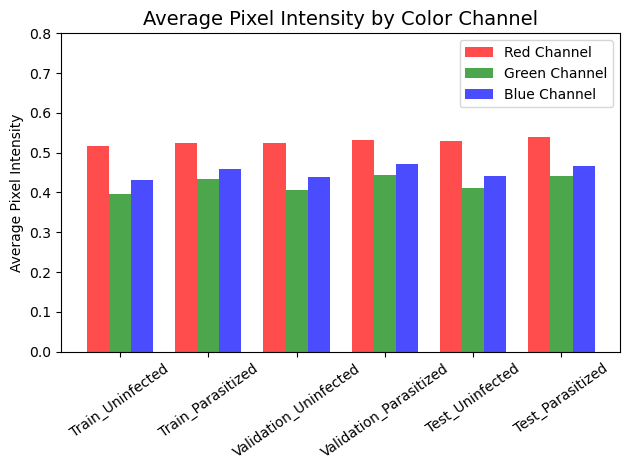

In [ ]:
bar_width = 0.25
indices = np.arange(len(img_arrays))

plt.bar(np.arange(len(img_arrays)), avg_red, width = 0.25, color = 'red', alpha = 0.7, label = 'Red Channel')
plt.bar(np.arange(len(img_arrays)) + bar_width, avg_green, width = 0.25, color = 'green', alpha = 0.7, label = 'Green Channel')
plt.bar(np.arange(len(img_arrays)) + 2 * bar_width, avg_blue, width = 0.25, color = 'blue', alpha = 0.7, label = 'Blue Channel')

plt.ylim(0, 0.8)
plt.ylabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Color Channel',fontsize=14)
plt.xticks(indices + bar_width, img_array_names, rotation = 35)
plt.legend()

plt.tight_layout()
plt.show();

### Dimensionality Reduction: RGB to Grayscale

After analyzing the pixel intensity values of each color channel for the uninfected and parasitized cells across all three datasets, it appears that the differences are quite small but could still have an impact on the model's performance. To determine the significance of retaining color information, experimenting with transforming the images in the train and validation sets into grayscale can be performed. By comparing the performance of the baseline models on the grayscale images with the performance on the original color images, the importance of color for the malaria detection task can be evaluated and determine whether it should be retained in the final model.

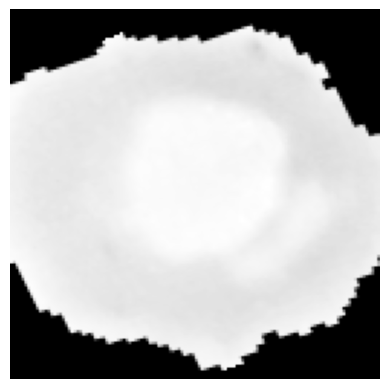

In [ ]:
# Visualize the 42nd image in x_train_batch_parasitized in grayscale
image_grayscale = color.rgb2gray(x_train_batch_parasitized[16])
plt.imshow(image_grayscale, cmap='Greys_r')
plt.axis('off');

#### Brightening the background

The background of the grayscale images is also brightened by setting the pixel values outside of the cells to the largest pixel value present in the image to ’brighten’ the background. This step ensures that the model will only focus on the pixels inside the cells, which is expected to help with the classification of grayscale images.

In [ ]:
# Function to brighten the grayscale image
def brighten(image):
    max_ = np.max(image)
    image[image == 0.0] = max_
    return image

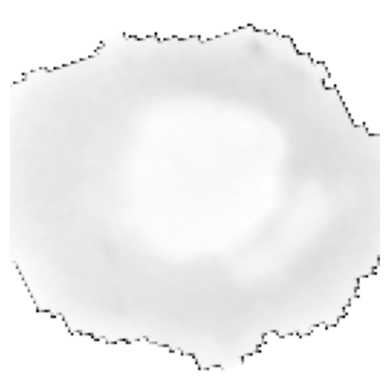

In [ ]:
# Example of what the brighten function does on the 165th image in the test set
img = brighten(image_grayscale)
plt.imshow(img, cmap='Greys_r')
plt.axis('off');

In [ ]:
# Grayscale and brighten the images for the train set
X_train_uninfected_bright = []
for img in x_train_batch_uninfected:
    img = color.rgb2gray(img)
    img = brighten(img)
    X_train_uninfected_bright.append(img)
X_train_uninfected_bright = np.array(X_train_uninfected_bright)

X_train_parasitized_bright = []
for img in x_train_batch_parasitized:
    img = color.rgb2gray(img)
    img = brighten(img)
    X_train_parasitized_bright.append(img)
X_train_parasitized_bright = np.array(X_train_parasitized_bright)

In [ ]:
# Grayscale and brighten the images for the validation set
X_valid_uninfected_bright = []
for img in x_valid_batch_uninfected:
    img = color.rgb2gray(img)
    img = brighten(img)
    X_valid_uninfected_bright.append(img)
X_valid_uninfected_bright = np.array(X_valid_uninfected_bright)

X_valid_parasitized_bright = []
for img in x_valid_batch_parasitized:
    img = color.rgb2gray(img)
    img = brighten(img)
    X_valid_parasitized_bright.append(img)
X_valid_parasitized_bright = np.array(X_valid_parasitized_bright)

In [ ]:
# Flatten
X_train_uninfected_bright = X_train_uninfected_bright.reshape(X_train_uninfected_bright.shape[0], -1)
X_train_parasitized_bright = X_train_parasitized_bright.reshape(X_train_parasitized_bright.shape[0], -1)
X_valid_uninfected_bright = X_valid_uninfected_bright.reshape(X_valid_uninfected_bright.shape[0], -1)
X_valid_parasitized_bright = X_valid_parasitized_bright.reshape(X_valid_parasitized_bright.shape[0], -1)
# Merge into single array
X_train_full = np.row_stack((X_train_uninfected_bright, X_train_parasitized_bright))
X_valid_full = np.row_stack((X_valid_uninfected_bright, X_valid_parasitized_bright))
# Reshape array
X_train_full = X_train_full.reshape(-1, 128 * 128)
X_valid_full = X_valid_full.reshape(-1, 128 * 128)

### Dimensionality Reduction: Principal Component Analysis

Since the dataset is large, it would be of best interest to reduce the dimensionality of the dataset to achieve higher training efficiency. Hence, PCA is first on the full training data.

The idea behind PCA is to identify the underlying structure in the data and summarize it using a smaller set of variables that capture most of the variation in the data. The first principal component accounts for the most variation in the data, followed by the second, and so on.

### PCA and t-SNE on grayscale images

In [ ]:
# Fit PCA on train set and transform both train and validation set
pca = PCA(n_components = 100)
pca.fit(X_train_full)
X_train_pcs = pca.transform(X_train_full)
X_valid_pcs = pca.transform(X_valid_full)

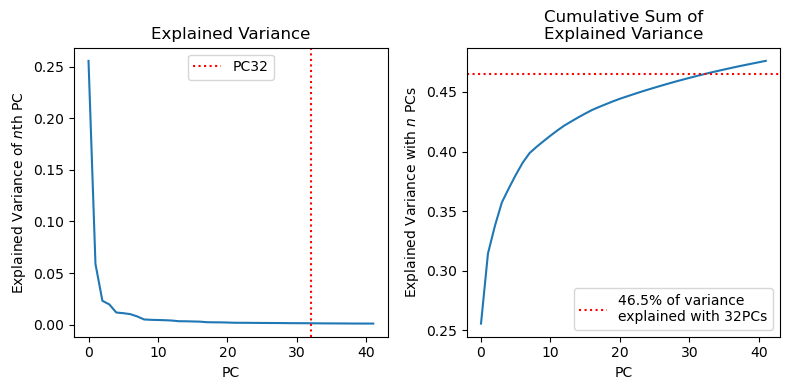

In [ ]:
# Plot explained variance of PCA
# first 32 PCs were selected as future analysis as it explains roughly 46% of variance
n_components = 32
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(pca.explained_variance_ratio_[:n_components+10])
axes[0].axvline(n_components,ls=':',label=f'PC{n_components}',color='red')
axes[0].set_title('Explained Variance')
axes[0].set_xlabel('PC')
axes[0].set_ylabel('Explained Variance of $n$th PC')
axes[0].legend()
axes[1].plot(np.cumsum(pca.explained_variance_ratio_)[:n_components+10])
axes[1].axhline(np.cumsum(pca.explained_variance_ratio_)[n_components],ls=':',
                label=f'{np.cumsum(pca.explained_variance_ratio_)[n_components]*100:.1f}% of variance\nexplained with {n_components}PCs',color='red')
axes[1].set_title('Cumulative Sum of\nExplained Variance')
axes[1].set_xlabel('PC')
axes[1].set_ylabel('Explained Variance with $n$ PCs')
axes[1].legend()
plt.tight_layout();

The first 32 principal components are only able to explain approximately 46% of the total variance within the training data.

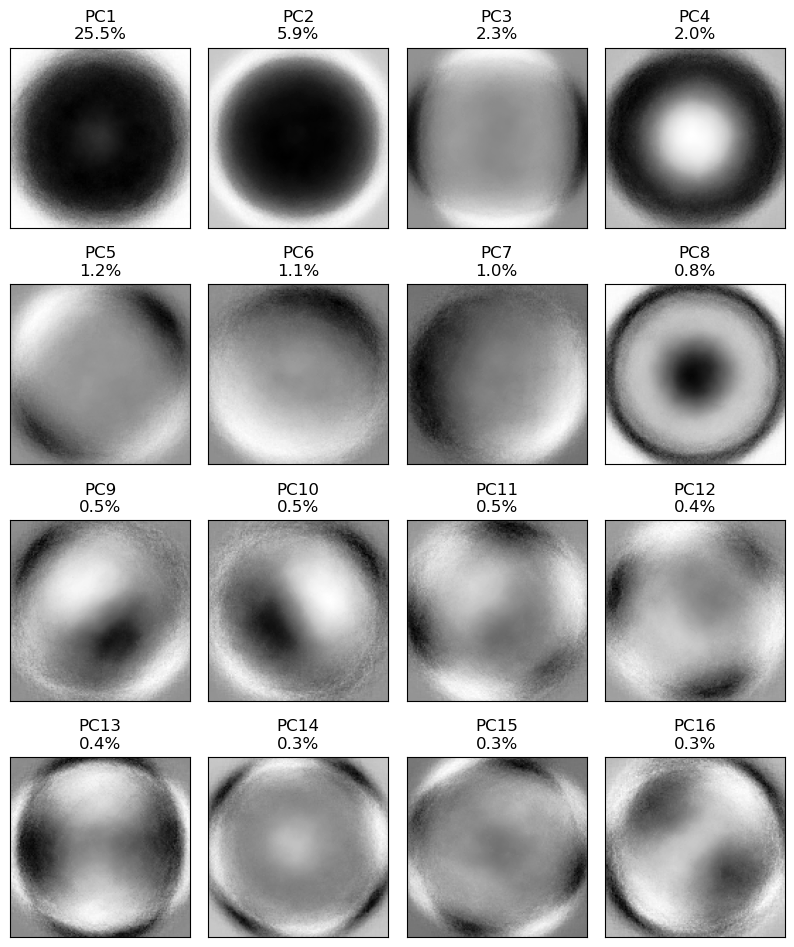

In [ ]:
# Visualize principal components
fig, axes = plt.subplots(4, 4, figsize=(10, 12),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(128, 128), cmap='Greys_r')
    ax.set_title(f'PC{i+1}\n{pca.explained_variance_ratio_[i]*100:.1f}%')

#### t-distributed stochastic neighbor embedding on PCA transformed train data [\[1\]](#ref) <a id="tsne"></a>

This project will be utilizing t-SNE (t-distributed stochastic neighbor embedding) as a technique for visualizing the high-dimensional PCA transformed train data in two dimensions. t-SNE is a powerful tool for identifying structure in complex datasets and can help to determine the effectiveness of the models for malaria detection.

t-SNE and PCA have different approaches to preserving the structure of high-dimensional data. While PCA aims to maximize variance by preserving the large pairwise distances between data points, t-SNE is focused on preserving the small pairwise distances or local similarities between nearby points. This allows t-SNE to capture more subtle, non-linear relationships between the data points, which can be particularly useful for visualizing complex datasets. 

The resulting t-SNE plot shows two clusters of data points, corresponding to the two classes: uninfected (green) and parasitized (red). The plot allows us to see how the data is distributed and to identify any patterns or relationships between the data points.

By visualizing the data in this way, it is possible to get a sense of how well the PCA transformation has captured the key features of the data and how well the models are able to classify the different classes. t-SNE can also be used to compare the performance of different models and to identify any areas where further improvement may be necessary.

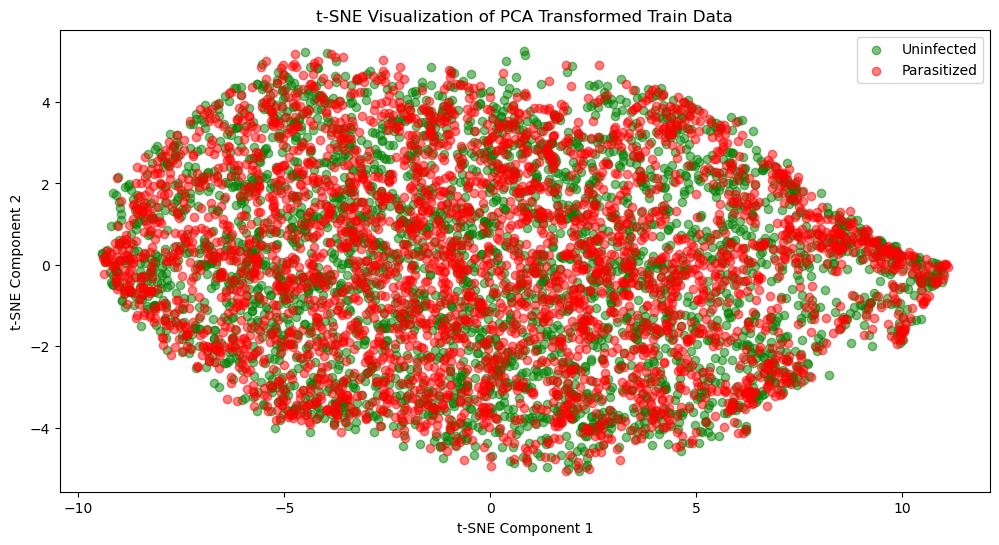

In [ ]:
tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300, random_state = 42)
X_train_tsne = tsne.fit_transform(X_train_pcs)

plt.figure(figsize=(12, 6))

labels = ['Uninfected', 'Parasitized']
colors = ['green', 'red']

for i, label in enumerate(labels):
    plt.scatter(X_train_tsne[y_train_batch == i, 0], X_train_tsne[y_train_batch == i, 1],
                color=colors[i], alpha=0.5, label=label)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of PCA Transformed Train Data')
plt.legend()
plt.show();

In this case, the t-SNE plot provides some important insights into the effectiveness of the PCA transformation. The two clusters of data points, corresponding to the uninfected and parasitized classes, appear to be heavily overlapping in the t-SNE plot, with many points from the uninfected class scattered throughout the parasitized cluster.

This suggests that the PCA transformation may not be capturing all of the relevant features that allow for accurate classification of the data, and that further feature engineering or alternative dimensionality reduction techniques may be necessary to improve the performance of the logistic regression model and SVM model. 

### PCA and t-SNE on colored images

In [ ]:
x_train_batch = x_train_batch.reshape(len(x_train_batch), -1)
x_valid_batch = x_valid_batch.reshape(len(x_valid_batch), -1)

In [ ]:
pca = PCA(n_components = 100)
pca.fit(x_train_batch)
X_train_pcs_color = pca.transform(x_train_batch)
X_valid_pcs_color = pca.transform(x_valid_batch)

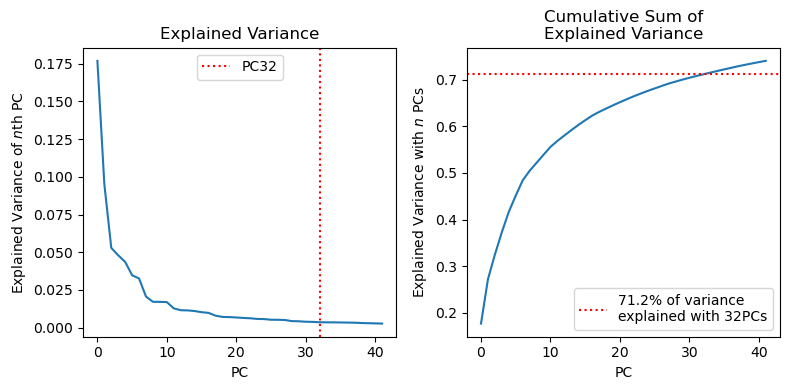

In [ ]:
# Plot explained variance of PCA
# first 32 PCs were selected as future analysis as it explains roughly 71% of variance
n_components = 32
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(pca.explained_variance_ratio_[:n_components+10])
axes[0].axvline(n_components,ls=':',label=f'PC{n_components}',color='red')
axes[0].set_title('Explained Variance')
axes[0].set_xlabel('PC')
axes[0].set_ylabel('Explained Variance of $n$th PC')
axes[0].legend()
axes[1].plot(np.cumsum(pca.explained_variance_ratio_)[:n_components+10])
axes[1].axhline(np.cumsum(pca.explained_variance_ratio_)[n_components],ls=':',
                label=f'{np.cumsum(pca.explained_variance_ratio_)[n_components]*100:.1f}% of variance\nexplained with {n_components}PCs',color='red')
axes[1].set_title('Cumulative Sum of\nExplained Variance')
axes[1].set_xlabel('PC')
axes[1].set_ylabel('Explained Variance with $n$ PCs')
axes[1].legend()
plt.tight_layout();

The first 32 principal components were able to explain 71.2% of the variance within the colored training dataset.

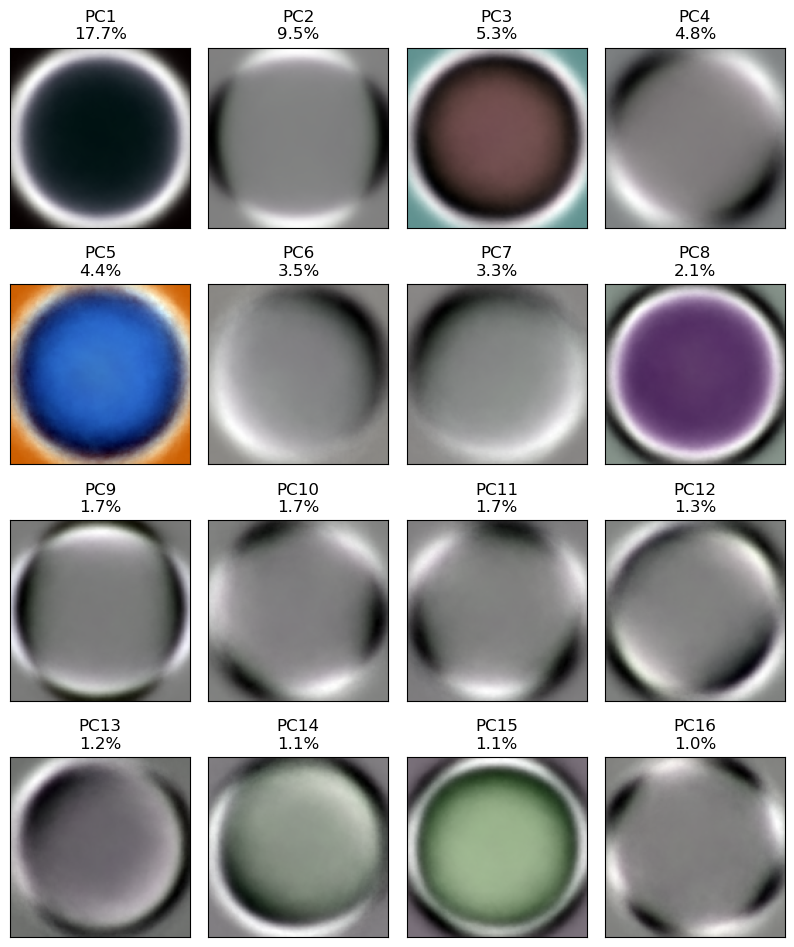

In [ ]:
# Visualize principal components
from sklearn.preprocessing import MinMaxScaler
fig, axes = plt.subplots(4, 4, figsize=(10, 12),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

scaler = MinMaxScaler()

for i, ax in enumerate(axes.flat):
    pc_reshaped = pca.components_[i].reshape(128, 128, 3)
    pc_normalized = scaler.fit_transform(pc_reshaped.reshape(-1, 3)).reshape(128, 128, 3)
    ax.imshow(pc_normalized)
    ax.set_title(f'PC{i+1}\n{pca.explained_variance_ratio_[i]*100:.1f}%')

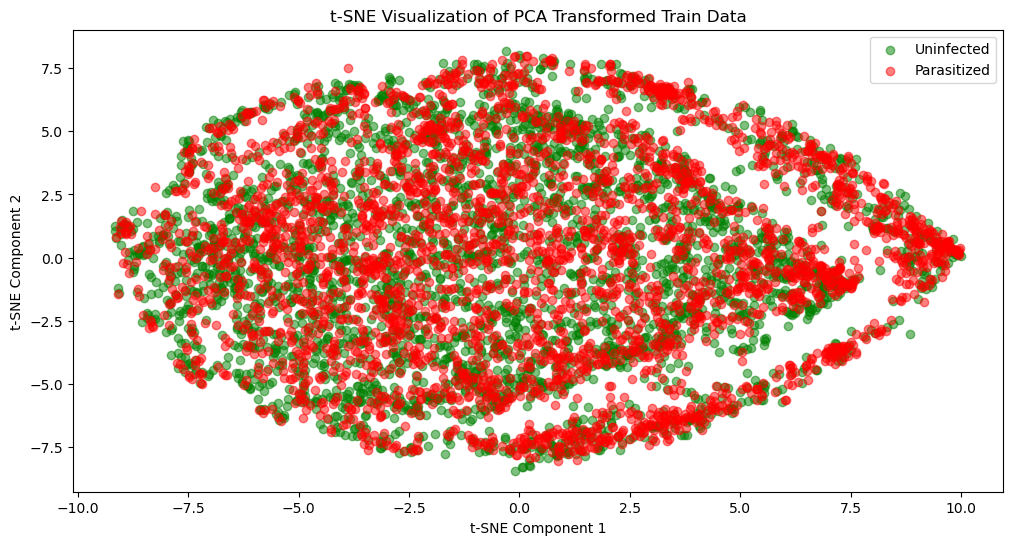

In [ ]:
tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300, random_state = 42)
X_train_tsne_color = tsne.fit_transform(X_train_pcs_color)

plt.figure(figsize=(12, 6))

labels = ['Uninfected', 'Parasitized']
colors = ['green', 'red']

for i, label in enumerate(labels):
    plt.scatter(X_train_tsne_color[y_train_batch == i, 0], X_train_tsne_color[y_train_batch == i, 1],
                color=colors[i], alpha=0.5, label=label)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of PCA Transformed Train Data')
plt.legend()
plt.show();

Similar to the t-SNE analysis on the grayscale images, the 2 clusters of the colored images also healily overlap each other. This suggests that the PCA transformation may not be capturing all of the relevant features that allow for accurate classification of the colored data as well.

## Baseline Models <a id="baseline"></a>

The baseline models, logistic regression and SVM trained on grayscaled images yielded roughly 50% validation accuracy, respectively. These results indicate that the models are not much better than random guessing, or may even perform worse. There are several possible reasons for these observations. Firstly, the data is highly dimensional, so the logistic regression model, which utilized only 32 principal components, might be too simplistic for accurate prediction. Additionally, during the dimensionality reduction step (in which we converted images to grayscale and performed PCA), key color information might have been lost. Since the 32 principal components explain only 46% of the total variance, it is highly likely that features which differentiate the two classes (Uninfected and Parasitized) are located in the principal components that explain smaller variances and were thus not included in the baseline model. 

On the other hand, with colored images, the two baseline models were able to obtain higher validation accuracies of 64.3% and 69.7%, respectively.

### Baseline Model - Logistic Regression on Grayscaled Images

For the first baseline model does not involve a neural network, a classification using logistic regression is performed with the first 32 principal components. Validation accuracy and confusion matrix were computed. The accuracy of the model is around 50%.

In [ ]:
# Fit the model and calculate validation accuracy
lr = LogisticRegression().fit(X_train_pcs[:,:n_components], y_train_batch)
y_valid_pred = lr.predict(X_valid_pcs[:,:n_components])
lr_acc = lr.score(X_valid_pcs[:,:n_components], y_valid_batch)
print(f'Accuracy of baseline model is {lr_acc*100:.2f}%')

Accuracy of baseline model is 49.27%


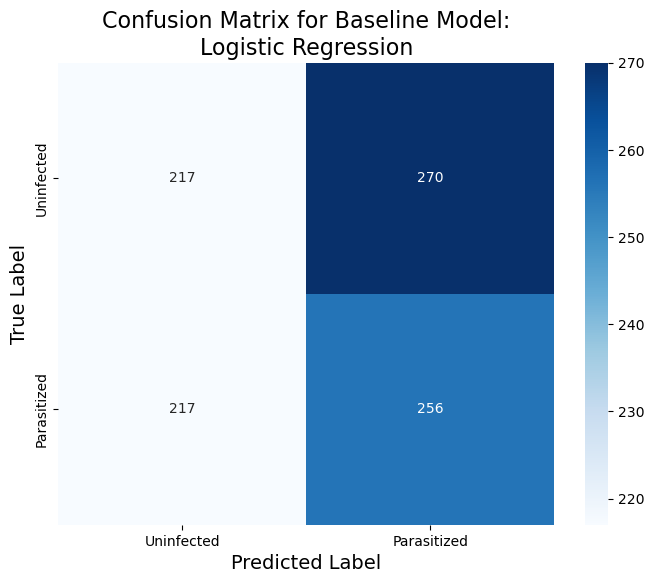

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_valid_batch, y_valid_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Baseline Model:\nLogistic Regression', fontsize = 16)
plt.show()

### Baseline Model - Logistic Regression on Colored Images

The same model is then trained on colored images to see whether the validation accuracy will be improved. The validation accuracy returned by the model is 64.3%, which is a moderate improvement from the one trained on grayscale images.

In [ ]:
# Fit the model and calculate validation accuracy
lr = LogisticRegression().fit(X_train_pcs_color[:,:n_components], y_train_batch)
y_valid_pred = lr.predict(X_valid_pcs_color[:,:n_components])
lr_acc = lr.score(X_valid_pcs_color[:,:n_components], y_valid_batch)
print(f'Accuracy of baseline model is {lr_acc*100:.2f}%')

Accuracy of baseline model is 64.27%


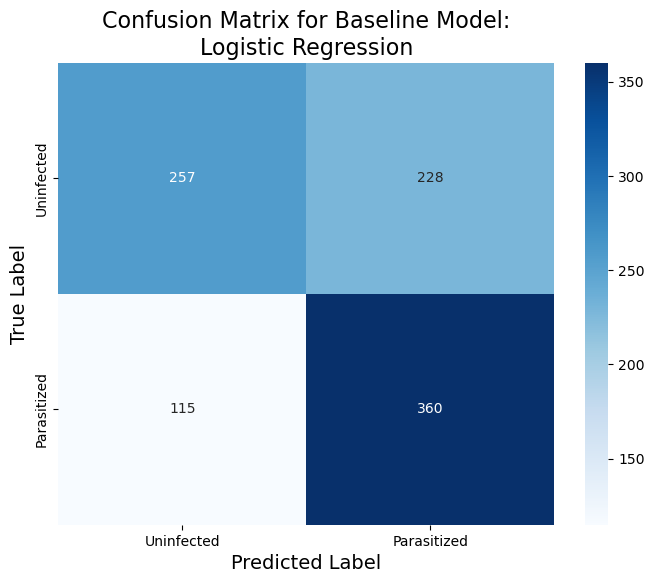

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_valid_batch, y_valid_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Baseline Model:\nLogistic Regression', fontsize = 16)
plt.show()

### Baseline Model - Support Vector Machine on Grayscaled Images [\[2\]](#ref) <a id="svm"></a>

As a second baseline model that does not involve neural network, a classification using support vector machine is performed.  

SVMs search for a hyperplane in a space with many dimensions that can divide the input data into different categories. The hyperplane is picked to have the largest margin, which is the distance between the hyperplane and the nearest data points from each category. Once found, this hyperplane is used by the SVM algorithm to classify new data points.

The motivation for choosing SVMs is due to their capability to process data that cannot be separated linearly by changing the input space to a higher-dimensional one where linear separation becomes feasible. This is accomplished using a kernel function that maps the initial input space to a higher-dimensional space with additional features. As parasitized cells can have a range of appearances in blood smears and may not be easily distinguishable from uninfected cells, it is possible that SVMs could be effective in identifying patterns and features in the data that may be indicative of parasitized cells.

The validation accuracy came to be around 50%. The confusion matrix were computed as was previously done in logistic regression case.  

In [ ]:
# Fit the model and calculate validation accuracy
clf = svm.SVC()
clf.fit(X_train_pcs, y_train_batch)

y_svm_pred = clf.predict(X_valid_pcs)
svm_acc = clf.score(X_valid_pcs, y_valid_batch)
print(f'Accuracy of baseline model is {svm_acc*100:.2f}%')

Accuracy of baseline model is 50.00%


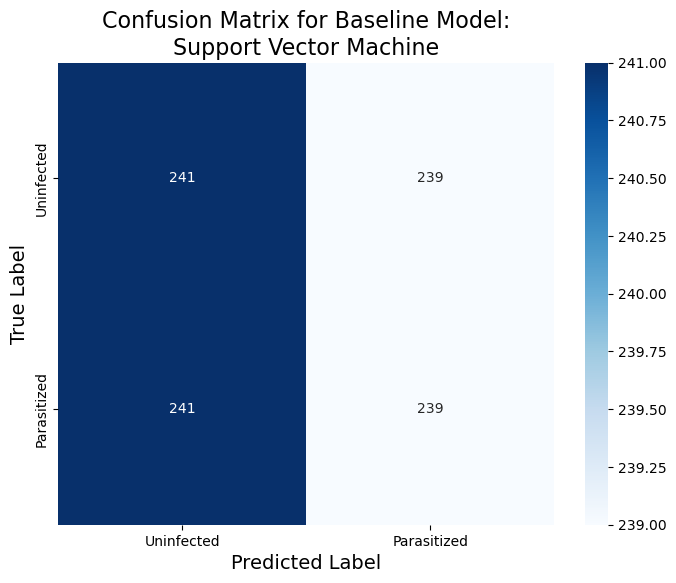

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_valid_batch, y_svm_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Baseline Model:\nSupport Vector Machine', fontsize = 16)
plt.show()

### Baseline Model - Support Vector Machine on Colored Images
Similar to logistic regression, the SVM model is also trained on colored images. Again, there is an improvement in model accuracy as the validation accuracy obtained on colored images is 69.7%.

In [ ]:
# Fit the model and calculate validation accuracy
clf = svm.SVC()
clf.fit(X_train_pcs_color, y_train_batch)

y_svm_pred = clf.predict(X_valid_pcs_color)
svm_acc = clf.score(X_valid_pcs_color, y_valid_batch)
print(f'Accuracy of baseline model is {svm_acc*100:.2f}%')

Accuracy of baseline model is 69.69%


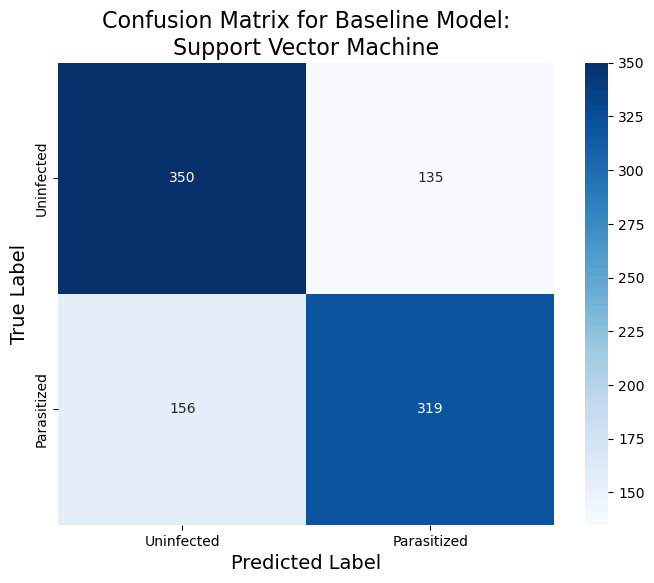

In [ ]:
#Plot confusion matrix
cm = confusion_matrix(y_valid_batch, y_svm_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Baseline Model:\nSupport Vector Machine', fontsize = 16)
plt.show()

From the 2 baseline models above, it is clear that color does play a significant role in model performance as it contains vital information about features of cell images. Hence the images cannot be reduced in dimensionality by turning them into grayscale images. From now on, the models will be trained on colored images.

## CNN <a id="cnn"></a>

As a starting point for the final model, a simple CNN model can be used. The CNN is trained on RGB images rather than grayscale images. This is due to the earlier conclusion from the baseline model that crucial features that distinguish uninfected and parasitized cells are highly likely to be lost during dimensionality reduction. With this CNN model as a starting point, hyperparameter tuning is performed to improve the performance.


### CNN without Tuning

To start, a simple CNN model was designed with 2 convolutional layers, each followed by a Maxpooling layer to extract only the most salient features. Then, the outputs were flattened, 1 fully-connected dense layer was added, and the data was batch-normalized to avoid exploding gradients. Finally, the model performed the classification task by passing the data through a sigmoid activation function. The architecture and flowchart of the model are shown as following.

The model was trained for 10 epochs but included early stopping with a patience of 3 epochs. If the validation accuracy does not increase after 3 epochs, the training will be terminated and the best trained weights will be restored. The model was trained on 30% of the full training dataset.

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape = (128, 128, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

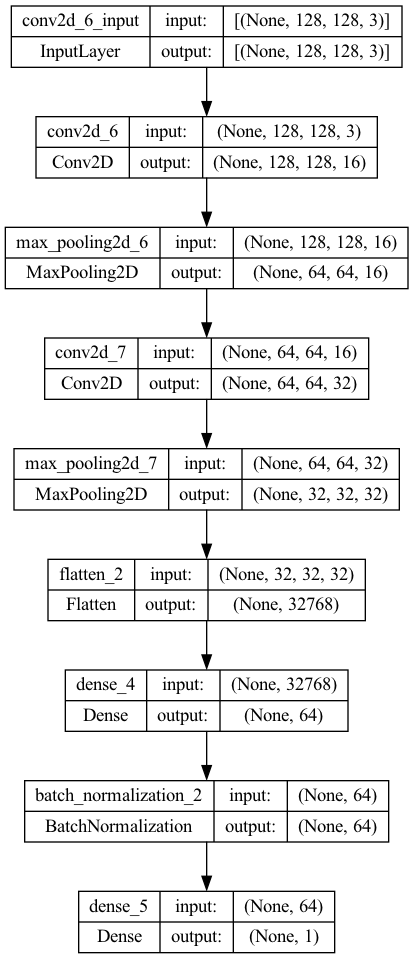

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_untuned_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
    x = x_train_batch, y = y_train_batch,
    epochs = epochs,
    validation_data = [x_valid_batch, y_valid_batch],
    callbacks = early_stop
    )
model.save_weights('cnn_colored_weights_untuned.h5')

Epoch 1/10


2023-05-07 14:02:29.524894: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


206/206 [==============================] - 15s 71ms/step - loss: 0.6358 - accuracy: 0.6479 - val_loss: 0.6673 - val_accuracy: 0.6094
Epoch 2/10
206/206 [==============================] - 15s 73ms/step - loss: 0.5750 - accuracy: 0.7072 - val_loss: 0.6849 - val_accuracy: 0.5615
Epoch 3/10
206/206 [==============================] - 15s 72ms/step - loss: 0.5075 - accuracy: 0.7608 - val_loss: 0.7824 - val_accuracy: 0.5323
Epoch 4/10
206/206 [==============================] - 15s 73ms/step - loss: 0.3879 - accuracy: 0.8387 - val_loss: 0.7972 - val_accuracy: 0.6646
Epoch 5/10
206/206 [==============================] - 14s 70ms/step - loss: 0.3022 - accuracy: 0.8914 - val_loss: 0.4408 - val_accuracy: 0.8052
Epoch 6/10
206/206 [==============================] - 15s 75ms/step - loss: 0.2385 - accuracy: 0.9208 - val_loss: 0.5755 - val_accuracy: 0.7427
Epoch 7/10
206/206 [==============================] - 14s 70ms/step - loss: 0.1905 - accuracy: 0.9448 - val_loss: 0.5378 - val_accuracy: 0.7677
Epo

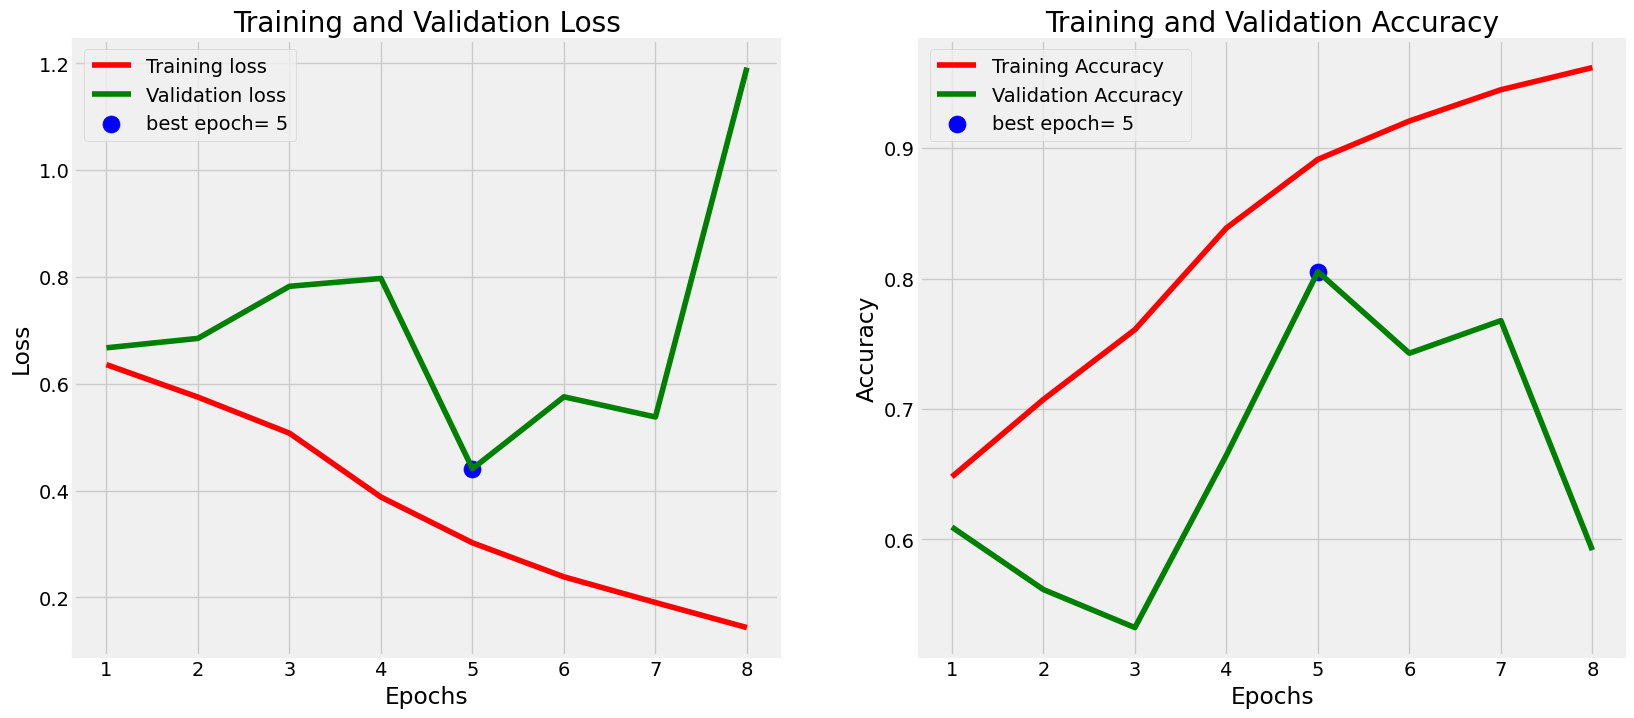

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Based on the training history for the baseline CNN model, it is clear that the training loss steadily decreases and training accuracy continuously increases. On the other hand, the validation loss and accuracy fluctuate throughout the training process. It is clear that the baseline CNN model requires fine-tuning. The test accuracy of this model is 0.81. 

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"The test accuracy is:{test_acc: .3f}")

35/35 [==============================] - 2s 47ms/step - loss: 0.4480 - accuracy: 0.8077
The test accuracy is: 0.808


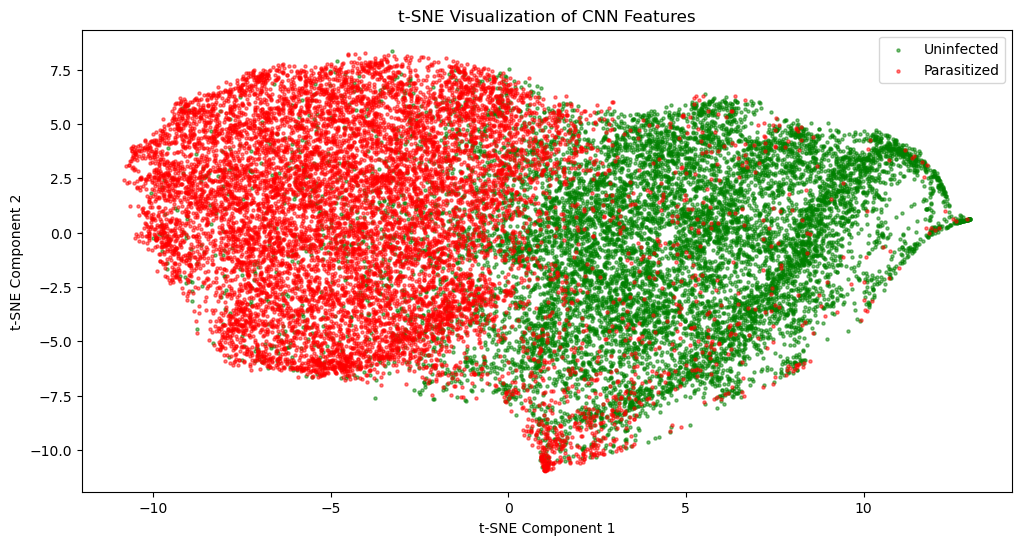

In [ ]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = []
y_train_gen_labels = []

for i in range(len(train_gen)):
    X_batch, y_batch = train_gen[i]
    features = feature_extractor.predict(X_batch, verbose=0)
    X_train_features.extend(features)
    y_train_gen_labels.extend(y_batch)

X_train_features = np.array(X_train_features)
y_train_gen_labels = np.array(y_train_gen_labels)

tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300, random_state = 42)
X_train_tsne = tsne.fit_transform(X_train_features)

labels = ['Uninfected', 'Parasitized']
colors = ['green', 'red']

plt.figure(figsize = (12, 6))
for i, label in enumerate(labels):
    plt.scatter(X_train_tsne[y_train_gen_labels == i, 0], X_train_tsne[y_train_gen_labels == i, 1],
                color=colors[i], s = 5, alpha=0.5, label=label)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of CNN Features')
plt.legend()
plt.show()

The t-SNE plot of the base CNN model without tuning provides some initial insights into the separability of the uninfected and parasitized classes in the dataset. While the two clusters of data points do show some degree of separation, with the uninfected points generally clustering on the right side of the plot and the parasitized points on the left, there is still a significant amount of overlap in the middle of the plot. This suggests that the model is not yet able to fully distinguish between the two classes based on the available features and training. 

One possibility for this lack of separation is that the features that the CNN model is using to differentiate between the two classes may be more strongly correlated with t-SNE Component 1 than with Component 2. This means that the differences between the uninfected and parasitized points may be more apparent in the horizontal axis of the plot than in the vertical axis. 

Another possible explanation is that the lack of tuning in the base CNN model has limited its ability to fully separate the classes. By adjusting parameters such as the learning rate, adding more layers, and adding dropout, it may be possible to improve the model's performance and achieve greater separation between the clusters. 

35/35 [==============================] - 2s 47ms/step


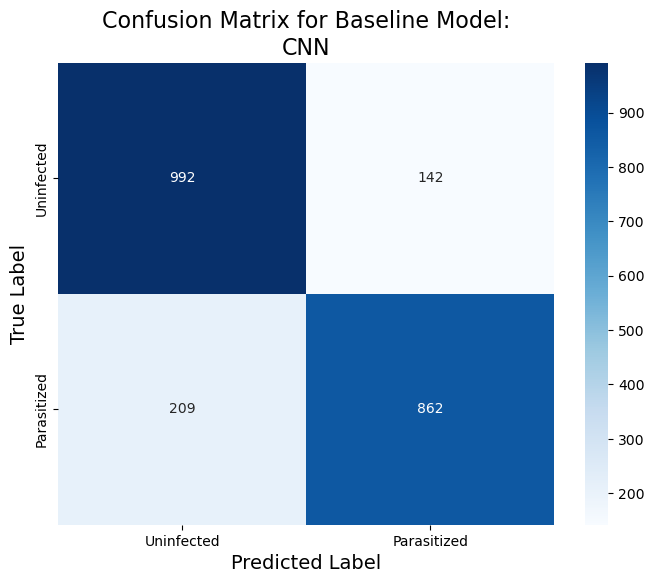

In [ ]:
# Plot confusion matrix
y_preds = model.predict(test_gen)
y_pred_labels = [1 if y_pred > 0.5 else 0 for y_pred in y_preds]
cm = confusion_matrix(test_gen.classes, y_pred_labels)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Baseline Model:\nCNN', fontsize = 16)
plt.show()

For the untuned CNN model, the confusion matrix is as shown above. The false positive and false negative rates are 14.3% and 24.2%, respectively. The model struggles with false negative cases the most, where the cells are classified as healthy while they are in truth parasitized. 

### Final CNN with Tuning

Several steps were taken to fine-tune the CNN model. First, the model complexity was increased by adding two more convolutional layers to extract more features from the training data. Dropout layers were then added after each maxpooling layer and the dropout rate was tuned to prevent the model from overfitting. It was found that setting the dropout rate to 0.2 provided the best accuracy. The learning rate of the optimizer was also increased to 0.0005 so that the model is less likely to get stuck in a gradient valley.

Similar to the baseline CNN model, the tuned model was trained for 10 epochs. Early stopping with a patience of 3 epochs was applied. If the validation accuracy does not increase for 3 epochs, the training would be terminated and the best trained weights would be restored.

Finally, the model was trained on the full training dataset instead of using only 30% so that the model has more information to learn from.

In [ ]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same', input_shape = (128, 128, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 16)       

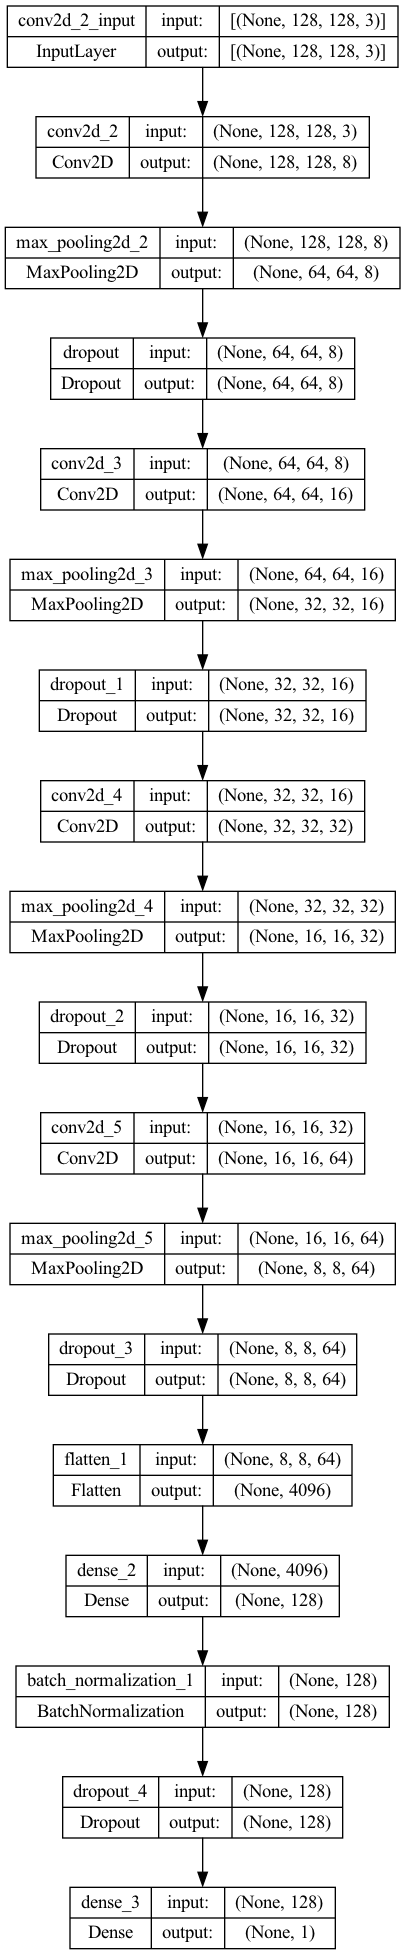

In [ ]:
plot_model(model, to_file='cnn_tuned_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = Adam(learning_rate = 0.0005, beta_1 = 0.9, beta_2 = 0.999)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
    train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = early_stop
    )
model.save_weights('cnn_colored_weights_base.h5')

Epoch 1/10
345/345 [==============================] - 55s 159ms/step - loss: 0.6715 - accuracy: 0.6232 - val_loss: 0.7263 - val_accuracy: 0.4923
Epoch 2/10
345/345 [==============================] - 55s 160ms/step - loss: 0.4653 - accuracy: 0.7740 - val_loss: 0.2456 - val_accuracy: 0.9138
Epoch 3/10
345/345 [==============================] - 56s 161ms/step - loss: 0.2086 - accuracy: 0.9314 - val_loss: 0.1810 - val_accuracy: 0.9410
Epoch 4/10
345/345 [==============================] - 58s 169ms/step - loss: 0.1806 - accuracy: 0.9413 - val_loss: 0.1618 - val_accuracy: 0.9480
Epoch 5/10
345/345 [==============================] - 55s 161ms/step - loss: 0.1688 - accuracy: 0.9462 - val_loss: 0.1550 - val_accuracy: 0.9495
Epoch 6/10
345/345 [==============================] - 57s 164ms/step - loss: 0.1618 - accuracy: 0.9482 - val_loss: 0.1612 - val_accuracy: 0.9441
Epoch 7/10
345/345 [==============================] - 56s 161ms/step - loss: 0.1587 - accuracy: 0.9489 - val_loss: 0.1664 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"The test accuracy is:{test_acc: .3f}")

35/35 [==============================] - 2s 45ms/step - loss: 0.1397 - accuracy: 0.9556
The test accuracy is: 0.956


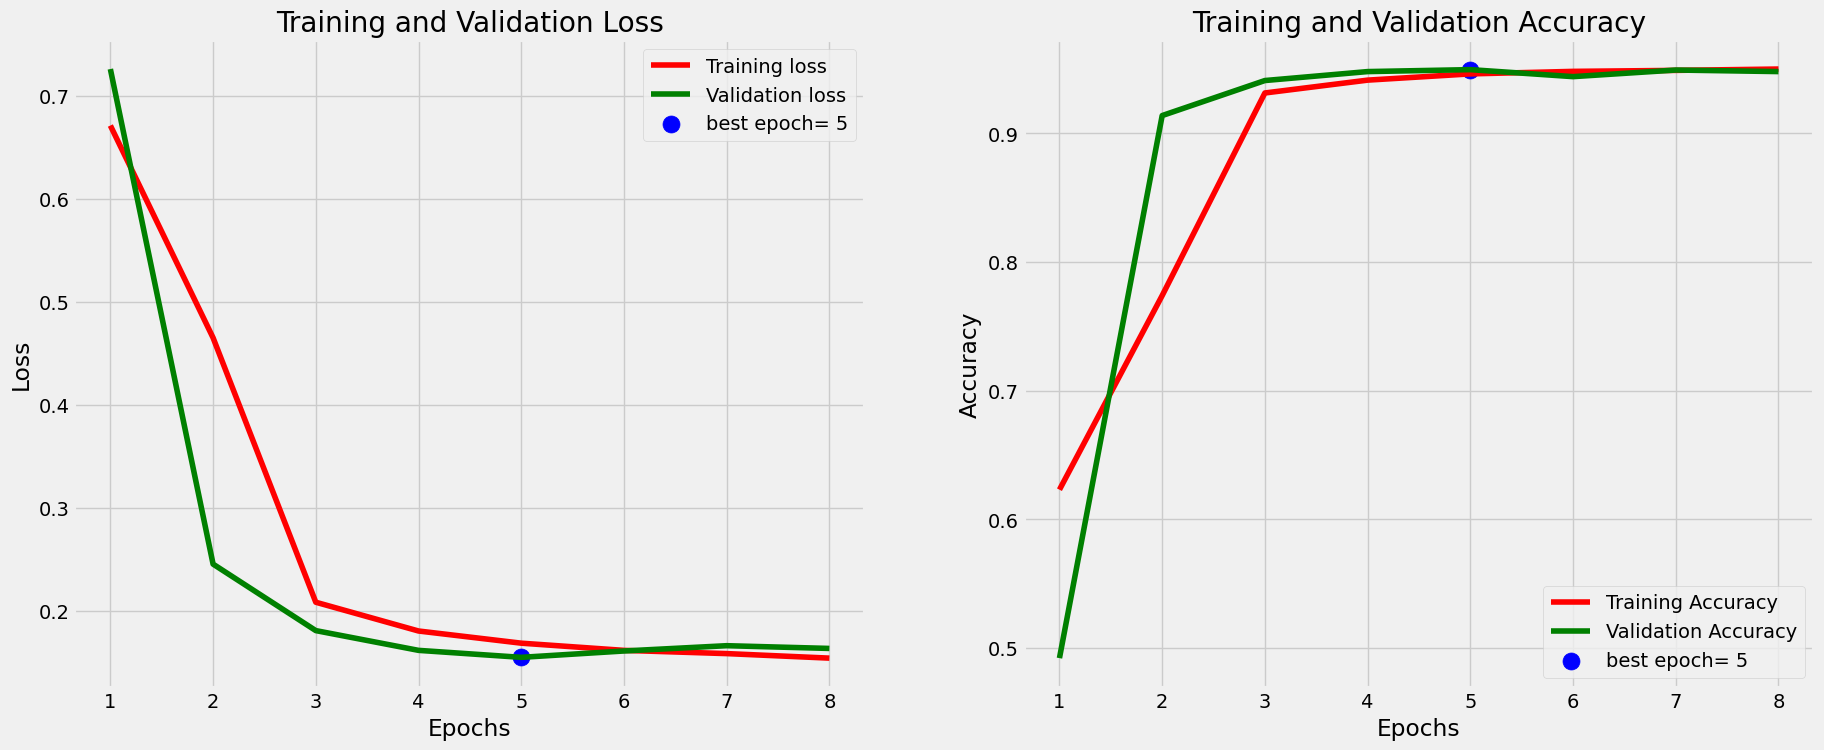

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

From the plots for the training history, both losses and accuracies for the training and validation converge as the number of epochs increases, which means that the model is not overfitting to the training data. The test accuracy of the tuned CNN model is 0.96.

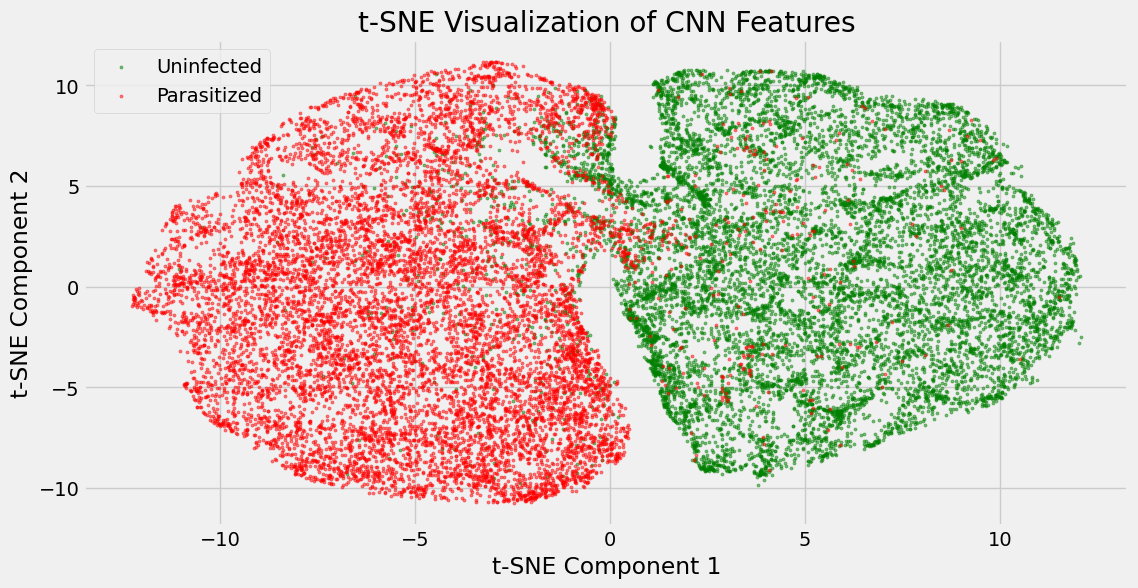

In [ ]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = []
y_train_gen_labels = []

for i in range(len(train_gen)):
    X_batch, y_batch = train_gen[i]
    features = feature_extractor.predict(X_batch, verbose=0)
    X_train_features.extend(features)
    y_train_gen_labels.extend(y_batch)

X_train_features = np.array(X_train_features)
y_train_gen_labels = np.array(y_train_gen_labels)

tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300, random_state = 42)
X_train_tsne = tsne.fit_transform(X_train_features)

labels = ['Uninfected', 'Parasitized']
colors = ['green', 'red']

plt.figure(figsize = (12, 6))
for i, label in enumerate(labels):
    plt.scatter(X_train_tsne[y_train_gen_labels == i, 0], X_train_tsne[y_train_gen_labels == i, 1],
                color=colors[i], s = 5, alpha=0.5, label=label)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of CNN Features')
plt.legend()
plt.show()

The t-SNE plot of the second CNN with tuning reveals that the model is able to more effectively separate the uninfected and parasitized classes in the dataset. The two clusters of data points are more distinct than in the base CNN model. However, there is still a section in the middle of the plot where the two clusters overlap, indicating that there may be some degree of similarity between the two classes the first t-SNE component is struggling to capture.

The improvement of the separation with the new CNN model is most likely attributed to the tuning performed, which allowed it to better identify and utilize the most relevant features for distinguishing between the two classes. By adjusting parameters such as the learning rate, number of layers, adding dropout, batch normalization, and increasing the depth of the CNN, the model may have been able to more effectively learn the distinguishing characteristics of the uninfected and parasitized cells, leading to better separation in the t-SNE plot.

 1/35 [..............................] - ETA: 5s

2023-05-06 21:35:48.118700: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - 2s 46ms/step


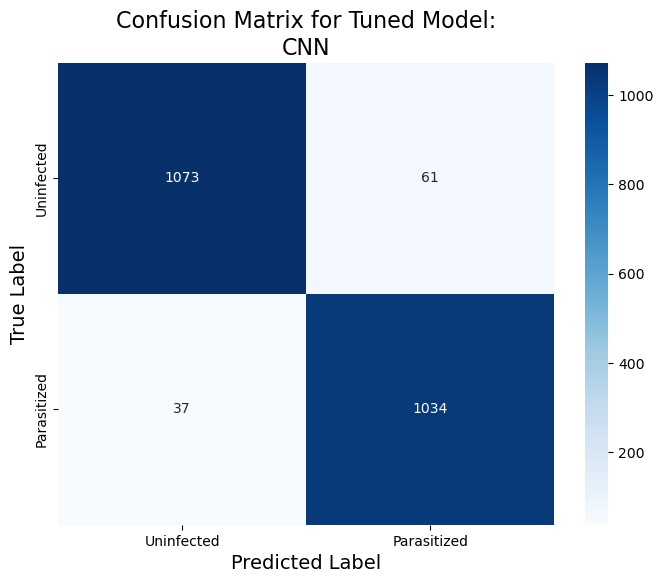

In [ ]:
model.load_weights('cnn_colored_weights_base.h5')
# Plot confusion matrix
y_preds = model.predict(test_gen)
y_pred_labels = [1 if y_pred > 0.5 else 0 for y_pred in y_preds]
cm = confusion_matrix(test_gen.classes, y_pred_labels)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for Tuned Model:\nCNN', fontsize = 16)
plt.show()

The final model was able to perform the task of differentiating the infected cells from healthy ones with a 96% accuracy. The false positive and negative rates are significantly improved from the untuned CNN model. However, it still yields a 3.6% false negative rate and 5.7% false positive rate. The false negative cases are definitely considered more dangerous in this scenario because the cell images that are in truth infected by malaria will not be correctly classified by the model. In other words, 36 people out of 1000 who are actually plagued by malaria will not test positive using this model.

## Conclusion & Future Work <a id="conclusion"></a>


The tuned CNN model was simple but effective. It was able to classify cell images as infected by malaria or healthy with a 0.96 accuracy. The biggest strength of the model was that it was highly efficient. For 8 epochs and with a total training time of less than 8 minutes, it was able to perform accurate predictions on test cell images. However, one limitation of the model is that it still yields a 3.6% false negative rate, which means that 3.6% of patients who are actually infected by malaria will not be detected and correctly identified by the model. This could lead to severe consequences as early intervention is the key to successful malaria treatment.

Therefore, to further improve the model accuracy and lower the false negative rate, transfer learning can be introduced as part of the future work. Pre-trained models such as VGG and GoogleNet are usually trained on large datasets and complex architectures, which makes them highly accurate. With moderate tuning, they can perform extremely well on specific downstream tasks. By leveraging these pre-trained models, a better performance can be achieved on the task of detecting malaria infected cells, even with limited training data. 

## References <a id="ref"></a>

[\[1\]](#tsne) Laurens van der Maaten and Geoffrey Hinton. Visualizing data using t-sne. Journal of Machine Learning Research, 9(86):2579–2605, 2008.

[\[2\]](#svm) Platt, John. Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods. Advances in large margin classifiers, 10(3): 61-74, 1997.